In [1]:
from google.colab import output
output.enable_custom_widget_manager()


In [2]:
from google.colab import drive
drive.mount('/content/MyDrive')


Mounted at /content/MyDrive


In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns


In [ ]:
# load dataset
df = pd.read_csv("/content/MyDrive/MyDrive/math_symbols_100x100.csv", dtype={'label': str})

# remove blank images based on pixel sum logic
pixel_columns = df.columns.drop('label')
df['sum_pixels'] = df[pixel_columns].sum(axis=1)
df = df[df['sum_pixels'] > 50]  # keep only non-blank
df.drop('sum_pixels', axis=1, inplace=True)

In [ ]:
# image preprocessing functions
def preprocess_image(flat_img):
    img = flat_img.reshape(100, 100).astype(np.uint8)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    coords = np.column_stack(np.where(img > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return img / 255.0  # normalize

In [ ]:
# apply preprocessing
features = df.drop('label', axis=1).values
preprocessed_images = np.array([preprocess_image(img) for img in features])
preprocessed_images = preprocessed_images.reshape(-1, 100, 100, 1)

In [ ]:
# encode labels
labels = df['label'].astype(str).values
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

In [ ]:
# split data
X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, encoded_labels, test_size=0.2, random_state=42)

# Compute class weights for imbalance
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

In [ ]:
# defining image augmentation to reduce overfitting, and generalize better
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15
)

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel9990', 'pixel9991', 'pixel9992', 'pixel9993', 'pixel9994',
       'pixel9995', 'pixel9996', 'pixel9997', 'pixel9998', 'pixel9999'],
      dtype='object', length=10001)


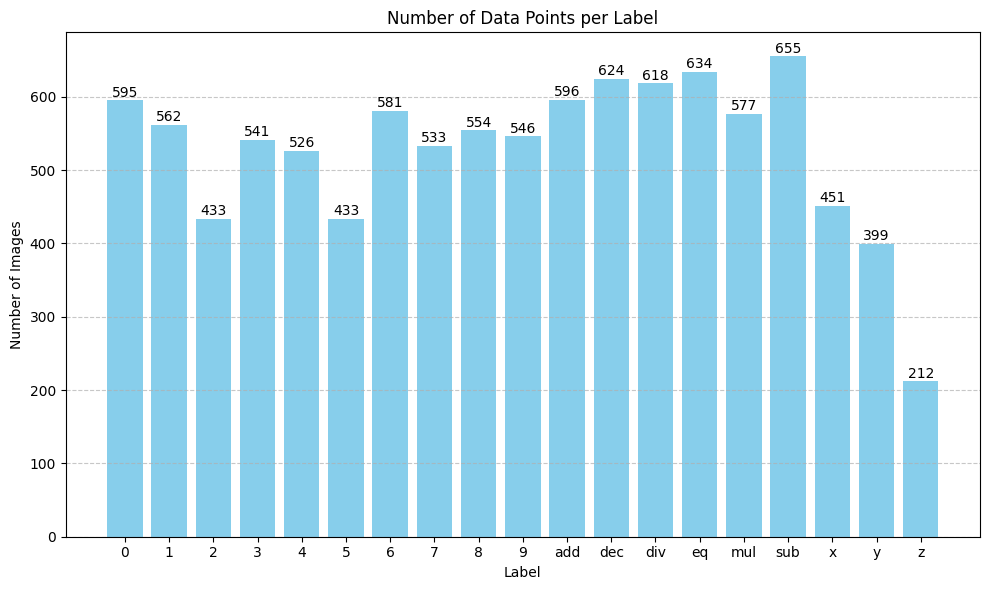

In [11]:
import matplotlib.pyplot as plt

# Check column names (you may need to change 'label' below)
print(df.columns)

# Count data points for each label
label_counts = df['label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color='skyblue')

# Add counts on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Number of Data Points per Label')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
counts = df['label'].value_counts()
print("Max class:", counts.idxmax(), "→", counts.max())
print("Min class:", counts.idxmin(), "→", counts.min())
print("Imbalance Ratio:", counts.max() / counts.min())


Max class: sub → 655
Min class: z → 212
Imbalance Ratio: 3.089622641509434


In [13]:
pixel_columns = df.columns.drop('label')
df['sum_pixels'] = df[pixel_columns].sum(axis=1)
blank_images = df[df['sum_pixels'] < 50]  # tweak threshold

print("Potential blank or bad images:", len(blank_images))
blank_images.head()


Potential blank or bad images: 0


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel9991,pixel9992,pixel9993,pixel9994,pixel9995,pixel9996,pixel9997,pixel9998,pixel9999,sum_pixels


In [ ]:
# writing the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(np.unique(y_train)), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# set callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [ ]:
# training model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=30,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights,
                    callbacks=[early_stop, checkpoint])


Epoch 1/30
  1/252 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9062 - loss: 0.2716

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9288 - loss: 0.2251 - val_accuracy: 0.9573 - val_loss: 0.1542
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9349 - loss: 0.2094 - val_accuracy: 0.9796 - val_loss: 0.0884
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9349 - loss: 0.2016

252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - accuracy: 0.9349 - loss: 0.2017 - val_accuracy: 0.9782 - val_loss: 0.0756
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.9353 - loss: 0.2174 - val_accuracy: 0.9747 - val_loss: 0.0847
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9389 - loss: 0.1839 - val_accuracy: 0.9667 - val_loss: 0.1323
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - accuracy: 0.9419 - loss: 0.1819 - val_accuracy: 0.9806 - val_loss: 0.0821
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9439 - loss: 0.1812 - val_accuracy: 0.9638 - val_loss: 0.1333
Epoch 8/30
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9455 - loss: 0.1844

252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9455 - loss: 0.1845 - val_accuracy: 0.9801 - val_loss: 0.0678
Epoch 9/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9430 - loss: 0.1712 - val_accuracy: 0.9821 - val_loss: 0.0759
Epoch 10/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9528 - loss: 0.1582 - val_accuracy: 0.9811 - val_loss: 0.0729
Epoch 11/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9565 - loss: 0.1513 - val_accuracy: 0.9782 - val_loss: 0.0833
Epoch 12/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9522 - loss: 0.1522 - val_accuracy: 0.9801 - val_loss: 0.0694
Epoch 13/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9509 - loss: 0.1563

252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9509 - loss: 0.1563 - val_accuracy: 0.9826 - val_loss: 0.0667
Epoch 14/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9574 - loss: 0.1550 - val_accuracy: 0.9757 - val_loss: 0.1034
Epoch 15/30
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9533 - loss: 0.1433

252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9533 - loss: 0.1434 - val_accuracy: 0.9836 - val_loss: 0.0666
Epoch 16/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9573 - loss: 0.1337 - val_accuracy: 0.9791 - val_loss: 0.0926
Epoch 17/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9591 - loss: 0.1259 - val_accuracy: 0.9801 - val_loss: 0.0854
Epoch 18/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9566 - loss: 0.1404 - val_accuracy: 0.9801 - val_loss: 0.0864
Epoch 19/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9621 - loss: 0.1266 - val_accuracy: 0.9757 - val_loss: 0.0889
Epoch 20/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9564 - loss: 0.1481 - val_accuracy: 0.9816 - val_loss: 0.0764


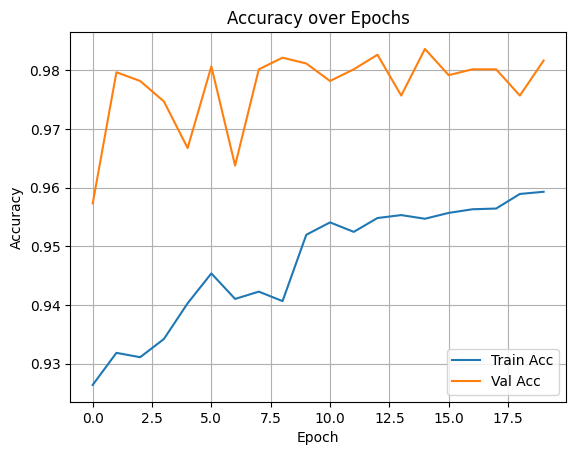

Final Train Accuracy: 0.9593
Final Validation Accuracy: 0.9816


In [ ]:
# plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# print model accuracy
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Final Train Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       130
           1       0.97      0.97      0.97       114
           2       1.00      0.99      0.99        85
           3       1.00      0.95      0.98       104
           4       0.99      0.98      0.98        92
           5       0.98      0.99      0.98        95
           6       0.97      1.00      0.98       118
           7       0.98      0.96      0.97       100
           8       0.95      0.98      0.97       108
           9       1.00      0.97      0.99       116
         add       0.96      1.00      0.98       135
         dec       0.99      1.00      1.00       120
         div       1.00      0.98      0.99       109
          eq       0.98      1.00      0.99       127
         mul       0.98      0.99      0.98       122
         sub       0.98      0.98      0.98       118
           x       1.00      0.99      0.9

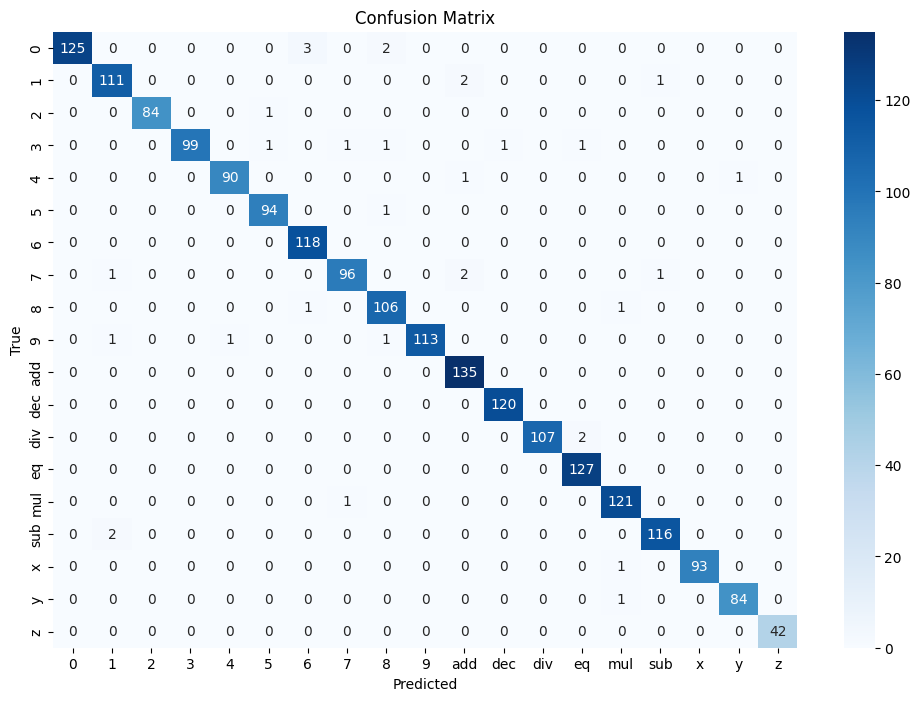

In [21]:
# Confusion Matrix and Classification Report
y_pred = model.predict(X_test).argmax(axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()